In [8]:
# Load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_csv('day.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [6]:
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import shap

In [2]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: Picked up _JAVA_OPTIONS: -Xmx6048m; openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu120.04, mixed mode, sharing)
  Starting server from /home/heriG/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptrd41sdm
  JVM stdout: /tmp/tmptrd41sdm/h2o_heriG_started_from_python.out
  JVM stderr: /tmp/tmptrd41sdm/h2o_heriG_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_heriG_iamb79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.906 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [10]:
# Select relevant columns
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

X = data[features]
y = data[target]


In [11]:
# One-hot encode categorical variables
cat_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(X[cat_features])

In [12]:
# Standardize numerical features
num_features = ['temp', 'atemp', 'hum', 'windspeed']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_features])

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([pd.DataFrame(X_encoded, columns=encoder.get_feature_names(cat_features)), pd.DataFrame(X_scaled, columns=num_features)], axis=1)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [15]:
# Convert data to H2O frame
train_data = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_data = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
# Define AutoML model
automl = H2OAutoML(max_runtime_secs=600, seed=42)
automl.train(x=X_train.columns.tolist(), y=target, training_frame=train_data)

# Get best model
best_model = automl.leader

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [18]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [22]:
# SHAP explanation for XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

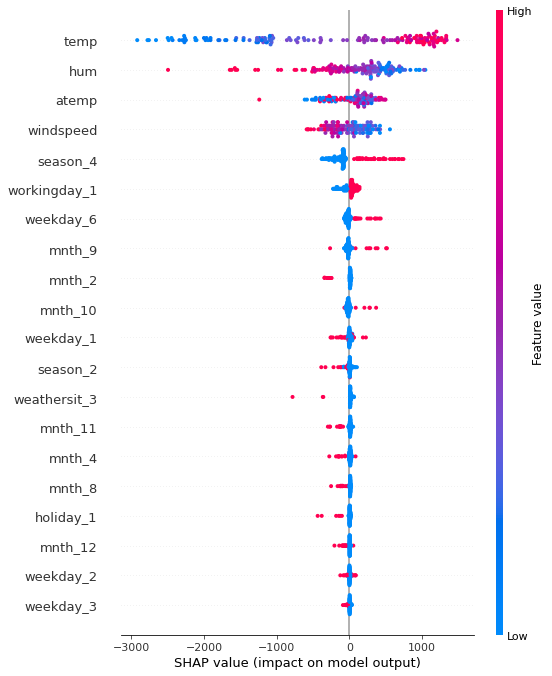

In [20]:
# SHAP plots for AutoML model
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Feature importance for AutoML model
feature_importance = best_model.varimp(use_pandas=True)

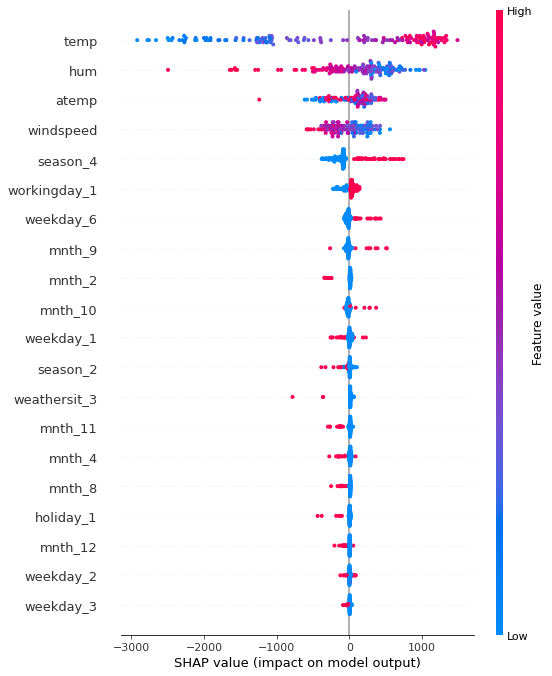

In [23]:
# SHAP plots for XGBoost model
shap.summary_plot(shap_values, X_test)

# Feature importance for XGBoost model
feature_importance = xgb_model.feature_importances_

# XGBoost model evaluation
mse = ((xgb_model.predict(X_test) - y_test) ** 2).mean()

In [24]:
# Report findings based on plots, feature importance, and model evaluation
print("Feature Importance:\n", feature_importance)
print("AutoML Model MSE:", best_model.mse())
print("XGBoost Model MSE:", mse)

Feature Importance:
 [0.02463987 0.02012752 0.11260589 0.02659045 0.01089022 0.01215804
 0.0326613  0.02236305 0.01011396 0.01368853 0.04365679 0.03527517
 0.03347346 0.0145866  0.03210113 0.01676969 0.0107905  0.01255673
 0.01636808 0.01730414 0.02320428 0.02122428 0.01431701 0.06190719
 0.2038714  0.06944182 0.05563287 0.03168011]
AutoML Model MSE: 598134.3558857703
XGBoost Model MSE: 1666942.8630818585
